<a href="https://colab.research.google.com/github/kAtharva4/nlp-proj-a/blob/main/Copy_of_LLM_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpletransformers

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.utils.class_weight import compute_class_weight

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# **1. Data Loading**

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

def load_and_explore_data(dataset_path):


    data = pd.read_csv(dataset_path)

    #exploratory Data Analysis
    print("=" * 50)
    print(" COMPREHENSIVE DATA ANALYSIS ")
    print("=" * 50)

    data['word_count'] = data['customer_message'].apply(lambda x: len(str(x).split()))

    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    data['encoded_sentiment'] = label_encoder.fit_transform(data['sentiment_label'])


    #label distribution
    plt.figure(figsize=(10, 6))
    label_counts = data['sentiment_label'].value_counts()

    #bar plot of label distribution
    plt.subplot(1, 2, 1)
    label_counts.plot(kind='bar')
    plt.title('Sentiment Label Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    #pie chart of label distribution
    plt.subplot(1, 2, 2)
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
    plt.title('Sentiment Label Percentage')
    plt.tight_layout()
    plt.show()

    #text length distribution by sentiment
    data['text_length'] = data['customer_message'].str.len()
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='sentiment_label', y='text_length', data=data)
    plt.title('Text Length Distribution by Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Text Length')
    plt.xticks(rotation=45)
    plt.show()


    #word cloud visualization
    from wordcloud import WordCloud

    plt.figure(figsize=(15, 5))
    for i, sentiment in enumerate(label_counts.index):
        plt.subplot(1, len(label_counts.index), i+1)
        subset = data[data['sentiment_label'] == sentiment]
        text = ' '.join(subset['customer_message'])

        wordcloud = WordCloud(width=800, height=400,
                               background_color='white',
                               min_font_size=10).generate(text)

        plt.imshow(wordcloud)
        plt.title(f'Word Cloud - {sentiment}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

     # Correlation heatmap
    plt.figure(figsize=(8, 6))
    numerical_cols = ['text_length', 'word_count']
    correlation_matrix = data[numerical_cols + ['encoded_sentiment']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    return data


# **2. Text Processing**

In [ ]:
def clean_text(text):

    #lowercase
    text = str(text).lower()

    #special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #tokenization
    tokens = word_tokenize(text)

    #stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [
        token for token in tokens
        if token.isalnum() and token not in stop_words
    ]

    #reconstruction text
    return ' '.join(tokens)

# **3. Text Embedding using BERT and RoBERTa**

In [ ]:
import torch
from simpletransformers.classification import ClassificationModel

def create_classification_models(num_labels, use_distilbert=False):

    #model arguments
    model_args = {
        "num_train_epochs": 2,
        "train_batch_size": 16,
        "eval_batch_size": 16,
        "learning_rate": 3e-5,
        "weight_decay": 0.01,
        "warmup_ratio": 0.1,
        "use_early_stopping": True,
        "early_stopping_patience": 2,
        "overwrite_output_dir": True,
        "save_model_every_epoch": False,
        "save_steps": -1,
        "dropout": 0.6
    }

    bert_model_name = "distilbert-base-uncased" if use_distilbert else "bert-base-uncased"

    models = {
        'bert': ClassificationModel(
            'bert' if not use_distilbert else 'distilbert',
            bert_model_name,
            num_labels=num_labels,
            args=model_args,
            use_cuda=torch.cuda.is_available()
        ),
        'roberta': ClassificationModel(
            'roberta',
            'roberta-base',
            num_labels=num_labels,
            args=model_args,
            use_cuda=torch.cuda.is_available()
        )
    }

    return models


# **4. Model Training with BERT and RoBERTa**

In [ ]:
def train_models(models, train_df, val_df):

    trained_models = {}

    for name, model in models.items():
        print(f"\nTraining {name.upper()} Model:")
        model.train_model(train_df, eval_df=val_df)
        trained_models[name] = model

    return trained_models

# **5. Evaluation on Validation Set**

In [ ]:
def evaluate_models(models, val_df):

    results = {}

    for name, model in models.items():
        print(f"\nEvaluating {name.upper()} Model:")
        result, _, _ = model.eval_model(val_df)
        results[name] = result
        print(f"{name.upper()} Results: {result}")

    return results

# **6. Saving the Best Model**

In [ ]:
def save_models(models):

    for name, model in models.items():
        model.save_model(f'{name}_sentiment_model')
        print(f"Saved {name.upper()} model")

# **7. Prediction on Real-World Input**

In [ ]:
def predict_sentiment(models, label_map, interactions):

    reverse_label_map = {v: k for k, v in label_map.items()}
    predictions = {}
    for name, model in models.items():
        preds, _ = model.predict(interactions)
        predictions[name] = [(interaction, reverse_label_map[pred]) for interaction, pred in zip(interactions, preds)]
    return predictions

# **Main Execution**

 COMPREHENSIVE DATA ANALYSIS 


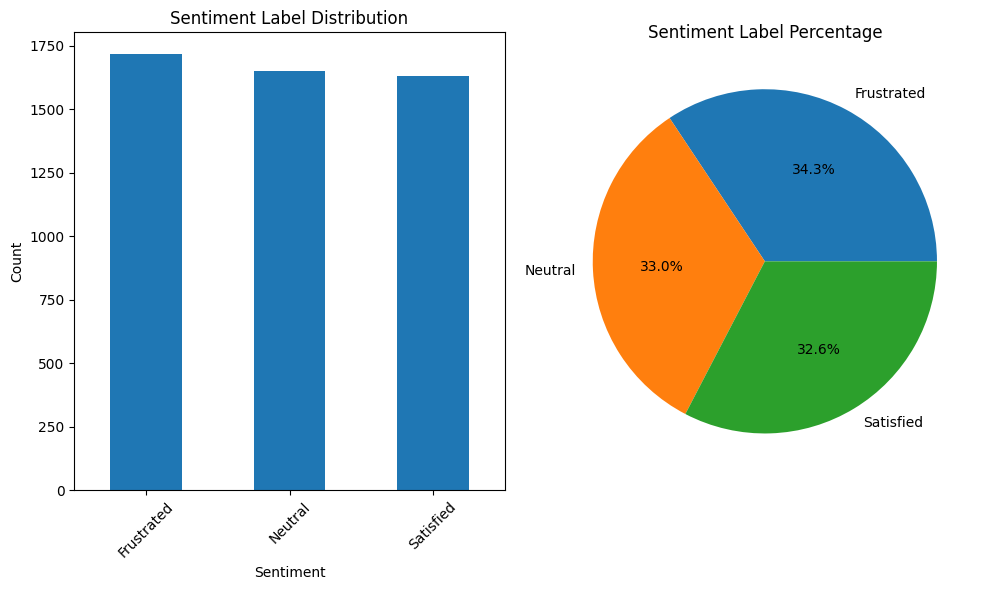

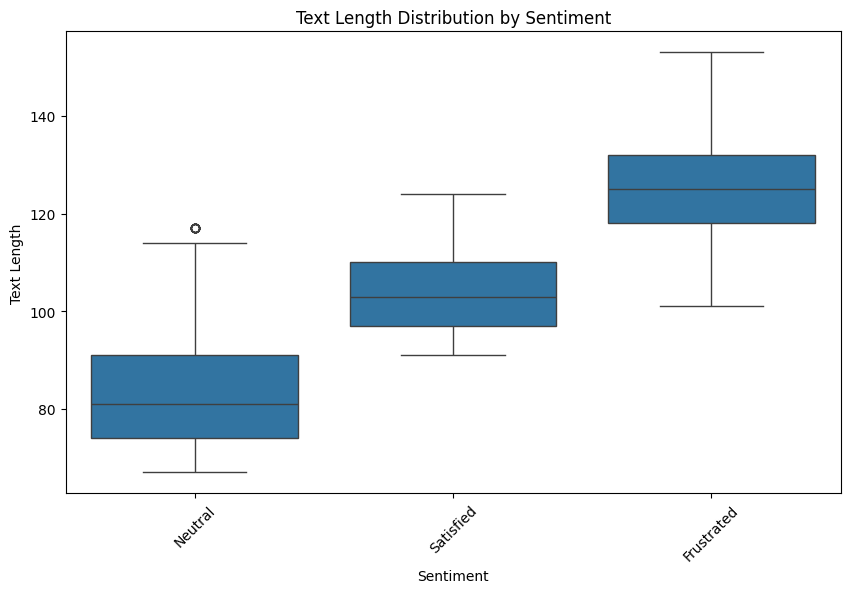

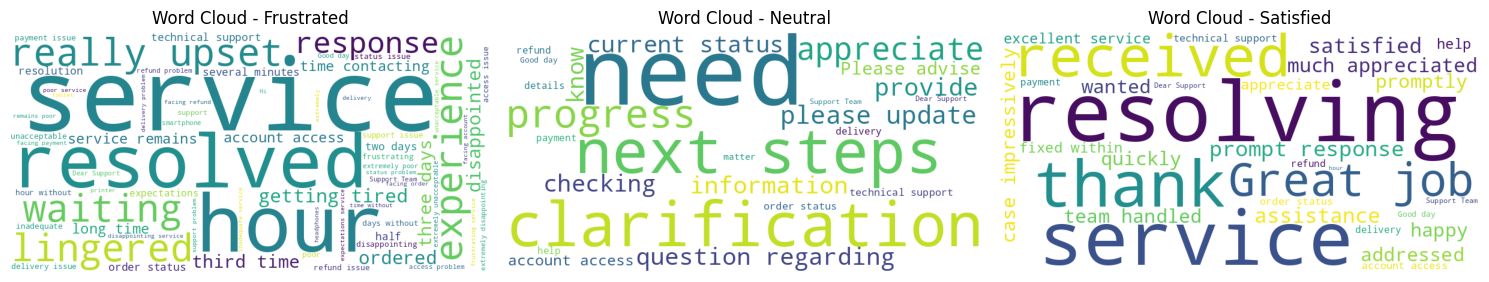

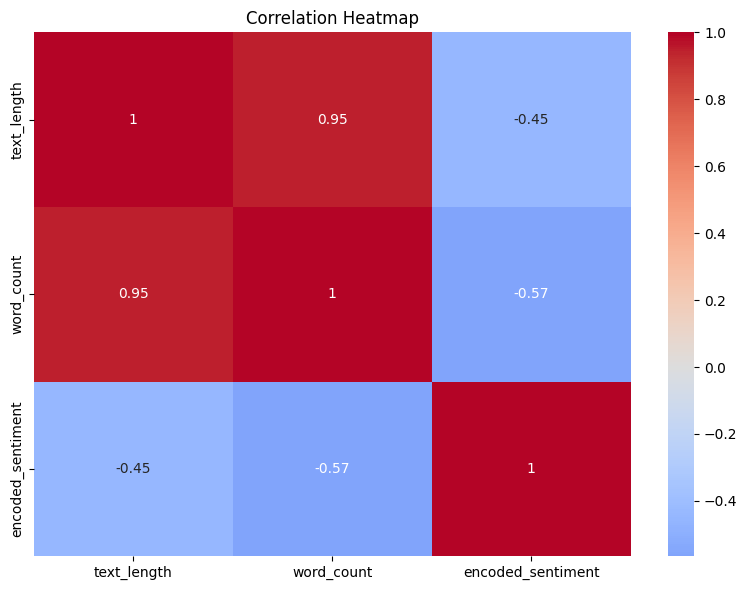

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training BERT Model:


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 2:   0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 2:   0%|          | 0/250 [00:00<?, ?it/s]


Training ROBERTA Model:


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 2:   0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 2:   0%|          | 0/250 [00:00<?, ?it/s]


Evaluating BERT Model:


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


BERT Results: {'mcc': np.float64(1.0), 'eval_loss': 0.00034409335681370327}

Evaluating ROBERTA Model:


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


ROBERTA Results: {'mcc': np.float64(1.0), 'eval_loss': 0.00017998615900675455}
Saved BERT model
Saved ROBERTA model


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Real-World Predictions:
BERT Predictions:
Sentence: 'I'm really happy with the service!' -> Prediction: Satisfied
Sentence: 'This is the worst experience I've had.' -> Prediction: Frustrated
Sentence: 'Can you help me with my order?' -> Prediction: Neutral
ROBERTA Predictions:
Sentence: 'I'm really happy with the service!' -> Prediction: Satisfied
Sentence: 'This is the worst experience I've had.' -> Prediction: Frustrated
Sentence: 'Can you help me with my order?' -> Prediction: Neutral


In [ ]:
def main():
    dataset_path = '/content/customer_service_sentiment - meaningful_customer_service_sentiment.csv.csv'
    data = load_and_explore_data(dataset_path)
    data['cleaned_text'] = data['customer_message'].apply(clean_text)
    label_encoder = LabelEncoder()
    data['encoded_sentiment'] = label_encoder.fit_transform(data['sentiment_label'])
    label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    train_data, val_data = train_test_split(
        data[['cleaned_text', 'encoded_sentiment']], test_size=0.2, stratify=data['encoded_sentiment'], random_state=42
    )

    train_df = pd.DataFrame({'text': train_data['cleaned_text'], 'labels': train_data['encoded_sentiment']})
    val_df = pd.DataFrame({'text': val_data['cleaned_text'], 'labels': val_data['encoded_sentiment']})

    models = create_classification_models(num_labels=len(label_map))
    trained_models = train_models(models, train_df, val_df)
    results = evaluate_models(trained_models, val_df)
    save_models(trained_models)

    #prediction
    sample_inputs = [
        "I'm really happy with the service!",
        "This is the worst experience I've had.",
        "Can you help me with my order?"
    ]
    predictions = predict_sentiment(trained_models, label_map, sample_inputs)
    print("\nReal-World Predictions:")
    for model, preds in predictions.items():
        print(f"{model.upper()} Predictions:")
        for sentence, sentiment in preds:
            print(f"Sentence: '{sentence}' -> Prediction: {sentiment}")

if __name__ == "__main__":
    main()